# ノイズスケジューラの動作確認

`Section 03: Basics of Diffusion Model` の `Lecture 09: Denoising Diffusion Probabilistic Model (1)` にて、ノイズ除去拡散確率モデル (denoising probabilistic diffusion model; DDPM) [[Ho+ NeurIPS'20]](https://arxiv.org/abs/2006.11239) について説明しました。

拡散過程において付与されるノイズは `ノイズスケジューラ` によって決定します。以下、ノイズスケジューラの簡易的な実装方法について紹介します。

## 拡散過程 - forward diffusion process

拡散過程はステップ $0$ から $T$ まで入力画像に徐々にノイズを加えていくものです。この過程は関数 $q$ として、以下のように定義されます:

$$
    q(\boldsymbol{x}_t | \boldsymbol{x}_0) = \mathcal{N}(\boldsymbol{x}_t; \sqrt{\bar{\alpha}}_t\boldsymbol{x}_0, (1 - \bar{\alpha}_t)\boldsymbol{I}).
$$

ここで $x_0$ は初期ステップでの画像 (元画像) であり、$x_t$ はステップ $t$ におけるノイズ画像です。$\bar{\alpha}_t$ は付与するノイズを決定するノイズスケジューラです。

## ノイズスケジューラの定義

ノイズスケジューラ $\bar{\alpha}$ は次のように定義されます:

$$
    \bar{\alpha}_t = \prod_{s=1}^t \alpha_s.
$$

ここで $\alpha_t$ は次のように定義されます:

$$
    \alpha_t = 1 - \beta_t.
$$

スケジューラの値が小さいほどより多くのノイズが追加されます。DDPM [[Ho+ NeurIPS'20]](https://arxiv.org/abs/2006.11239) では、$\alpha_t$ を $1 - \beta_t$ として定義し、$\bar{\alpha}$ をステップ $0$ から $t$ までの $\alpha$ の累積積として使用しています。

以上より、今度は $\beta_t$ がノイズスケジューラとなります。DDPM [[Ho+ NeurIPS'20]](https://arxiv.org/abs/2006.11239) では $10^{-4}$ から $0.02$ の間の値を示す線形スケジューラを使用しています。これらの値はステップ $t-1$ に対する $t$ で追加されるノイズの量を示すパーセンテージのようなものを表していると考えられます。

## ノイズスケジューラの実装

まず $\bar{\alpha}$ は次のように実装できます:

In [1]:
def alpha_bar(t: int, T: int) -> float:
    alpha_values = [alpha(s, T) for s in range(t)]
    ret = 1
    for alpha_value in alpha_values:
        ret *= alpha_value
    return ret

次に $\alpha_t$ は次のように実装できます:

In [2]:
def alpha(t: int, T: int) -> float:
    return 1 - beta(t, T)

最後に $\beta_t$ は次のような線形スケジューラとして実装できます:

In [3]:
def beta(t: int, T: int, upper: float = 0.02, lower: float = 10 ** -4) -> float:
    if t == 0:
        return lower
    return (upper - lower) / T * t + lower

## ノイズスケジューラの動作可視化

上記で実装した式を使用して、ノイズスケジューラの動作を可視化してみます。$T = 1000$ として設定し、$\bar{\alpha}_t$ の値を計算します。

In [4]:
T = 1000
ts = list(range(T)) # 0 ~ T までの値が入ったリストを作成

In [5]:
alpha_bar_values = [alpha_bar(t, T) for t in ts]

上記で得た `\bar{\alpha}_t` を元にグラフにプロットしてみます。

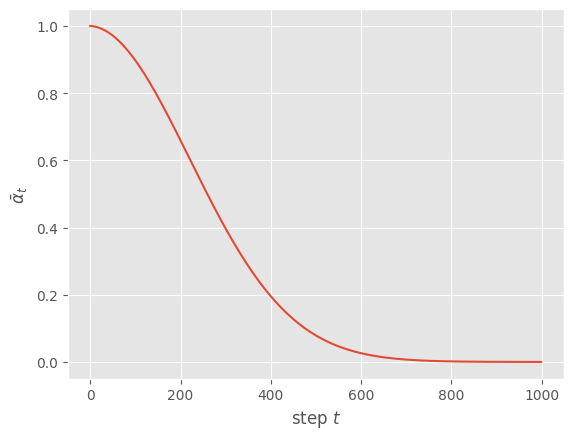

In [6]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

fig, ax = plt.subplots()
ax.set_xlabel("step $t$")
ax.set_ylabel("$\\bar{\\alpha}_t$")
ax.plot(ts, alpha_bar_values)